In [70]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt

import matplotlib.pyplot as plt
from scipy.stats import boxcox

from tqdm.notebook import tqdm

### ДЗ
1. Выберите ряд из первого задания и постройте его модель ARIMA. Отчет нужно будет оформить в jupyter-ноутбук.
1. Попробуйте спрогнозировать график классическим ML.

In [2]:
robberies_in_boston = pd.read_csv("../HW_1/Series/monthly-boston-armed-robberies-j.csv")

In [3]:
series = robberies_in_boston.Count

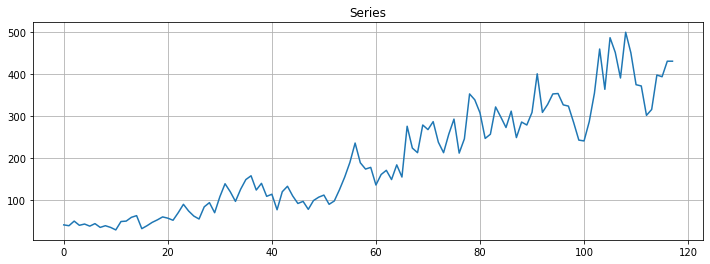

In [4]:
fig = plt.figure(figsize=(12,4))
plt.plot(series)
plt.grid()
plt.title('Series');

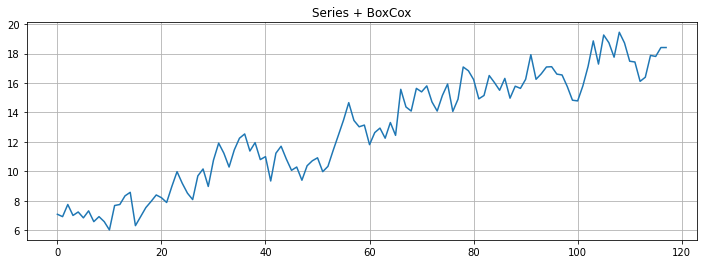

In [5]:
fig = plt.figure(figsize=(12,4))
series = boxcox(series)[0]
plt.plot(series)
plt.grid()
plt.title('Series + BoxCox');

In [6]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(series,order=(2,1,2), trend='n')

In [7]:
res = model.fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


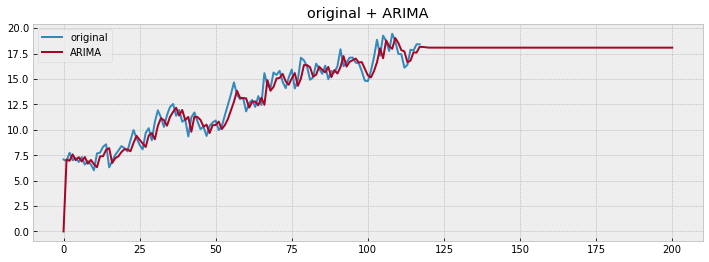

In [8]:
with plt.style.context(style='bmh'):
    plt.figure(figsize=(12,4))
    ax = plt.axes()
    plt.plot(series,label='original')
    plt.plot(range(0,201),res.predict(0,200),label='ARIMA' )
    plt.legend()
    plt.title('original + ARIMA')

In [9]:
res.aic

329.8663947417263

In [10]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  118
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -159.933
Date:                Tue, 10 Aug 2021   AIC                            329.866
Time:                        20:12:46   BIC                            343.677
Sample:                             0   HQIC                           335.473
                                - 118                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2984      0.584     -0.511      0.610      -1.444       0.847
ar.L2          0.1679      0.398      0.422      0.673      -0.613       0.948
ma.L1          0.0253      0.570      0.044      0.965      -1.092       1.142
ma.L2         -0.4496      0.491     -0.916      0.359      -1.411       0.512
sigma2         0.8996      0.119      7.535      0.000       0.666       1.134
===================================================================================
Ljung-Box (L1) (Q):                   0.30   Jarque-Bera (JB):                 1.28
Prob(Q):                              0.59   Prob(JB):                         0.53
Heteroskedasticity (H):               1.26   Skew:                             0.26
Prob(H) (two-sided):                  0.47   Kurtosis:                         3.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Судя по значению z и p, это значит НИ один коэффициент НЕ имеет статистическую значимость, ВСЕ коэффициенты MA и sigma(diff) статистически не значимы и стало быть ихиспользование не оправдано. 

Построим график остатков, если он не совпадает с нормальным, то это будет тоже фактором поменять исходные коэффициенты.  

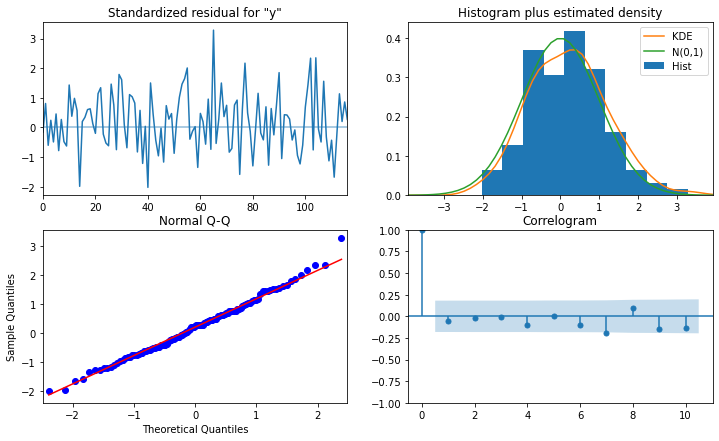

In [11]:
res.plot_diagnostics(figsize=(12,7));

График QQ-plot совпадает с нормальным распределением, кроме правого края, где не хватает низких значений

Уберем не значимыые коэффициенты и построим график.

In [12]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(series,order=(1,0,0), trend='n')

In [13]:
res = model.fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


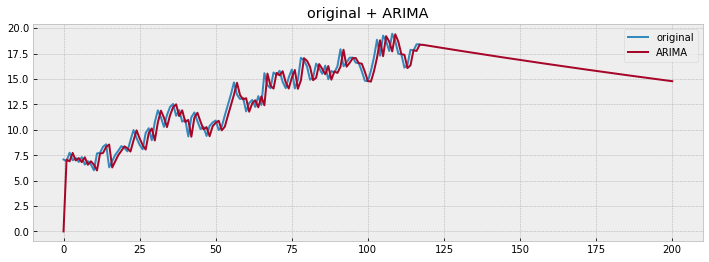

In [14]:
with plt.style.context(style='bmh'):
    plt.figure(figsize=(12,4))
    ax = plt.axes()
    plt.plot(series,label='original')
    plt.plot(range(0,201),res.predict(0,200),label='ARIMA' )
    plt.legend()
    plt.title('original + ARIMA')

In [15]:
res.aic

344.6917742836712

Критерий Акаике оказался хуже. Посмотим z-score:

In [16]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  118
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -170.346
Date:                Tue, 10 Aug 2021   AIC                            344.692
Time:                        20:12:48   BIC                            350.233
Sample:                             0   HQIC                           346.942
                                - 118                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9974      0.005    194.841      0.000       0.987       1.007
sigma2         1.0049      0.143      7.052      0.000       0.726       1.284
===================================================================================
Ljung-Box (L1) (Q):                   6.42   Jarque-Bera (JB):                 1.01
Prob(Q):                              0.01   Prob(JB):                         0.60
Heteroskedasticity (H):               1.28   Skew:                             0.18
Prob(H) (two-sided):                  0.44   Kurtosis:                         2.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Cross validation

In [29]:
best_params = (0,0,0)
best_mse = np.inf

for p in tqdm(range(7)):
    for d in range(2):
        for q in range(7):
            model = ARIMA(series,order=(p,d,q), trend='n')
            res = model.fit(method_kwargs = {'maxiter':300}, method='statespace')
            if res.mse < best_mse:
                best_mse = res.mse
                best_params = (p,d,q)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [32]:
best_mse, best_params

(1.1953757579837365, (6, 1, 6))

In [33]:
model = ARIMA(series,order=best_params, trend='n')
res = model.fit(method_kwargs = {'maxiter':400}, method='statespace')

In [34]:
res.mse

1.1953757579837365

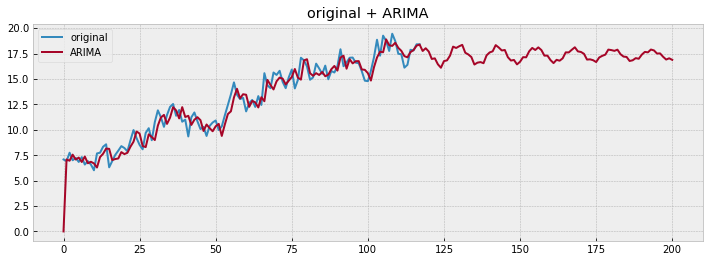

In [35]:
with plt.style.context(style='bmh'):
    plt.figure(figsize=(12,4))
    ax = plt.axes()
    plt.plot(series,label='original')
    plt.plot(range(0,201),res.predict(0,200),label='ARIMA' )
    plt.legend()
    plt.title('original + ARIMA')

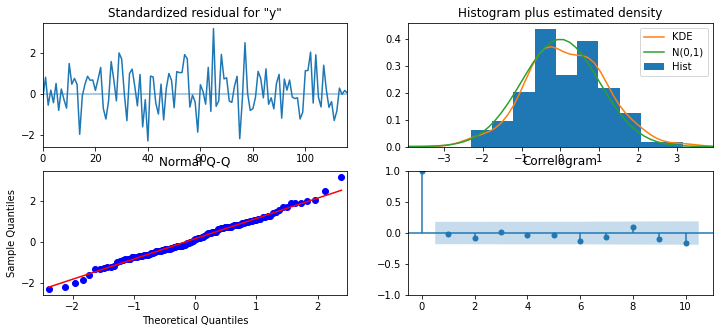

In [36]:
fig = plt.figure(figsize=(12,5))
res.plot_diagnostics(fig=fig)
plt.show()

### построим ML модель

In [38]:
df = pd.DataFrame(data=series,columns=['Count'] )

In [40]:
for i in range(30):
    df[f'lag_{i}'] = df.Count.shift(i)

In [51]:
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)
df.drop(columns=['Count'],inplace=True)

In [67]:
test_size = .15
train_length = int( len(df) * (1- test_size) )
delta = len(series) - len(df)
new_series = series[delta:]
X_train, X_test, y_train, y_test = df[:train_length], df[train_length :], new_series[:train_length] , new_series[train_length :] 

In [54]:
from sklearn.ensemble import RandomForestRegressor

In [71]:
best_mse = np.inf
max_depth = np.inf

for i in tqdm(range(5,300,5)):
    rf = RandomForestRegressor(n_estimators=100,criterion='mse', max_depth=i)
    rf.fit(X_train,y_train)
    y_pred = rf.predict(X_test)
    error = mean_squared_error(y_test,y_pred)
    if error< best_mse:
        max_depth = i
        best_mse = error

In [72]:
best_mse, max_depth

(0.49318788527548235, 55)

In [73]:
rf = RandomForestRegressor(n_estimators=100,criterion='mse', max_depth=55)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

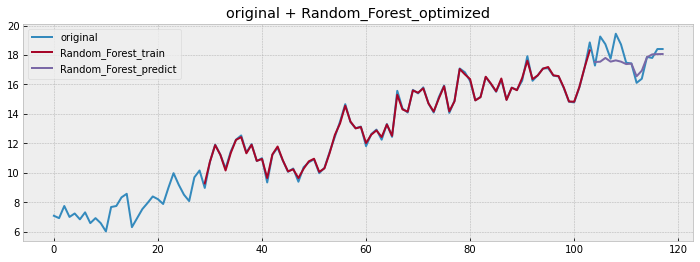

In [90]:
with plt.style.context(style='bmh'):
    plt.figure(figsize=(12,4))
    ax = plt.axes()
    plt.plot(series,label='original')
    
    plt.plot(range(delta,delta+len(y_train)),rf.predict(X_train),label='Random_Forest_train' )
    plt.plot(range(delta+len(y_train), len(series) ),y_pred,label='Random_Forest_predict' )
    
    plt.legend()
    plt.title('original + Random_Forest_optimized')

In [81]:
model = ARIMA(y_train,order=best_params, trend='n')
res = model.fit(method_kwargs = {'maxiter':400}, method='statespace')

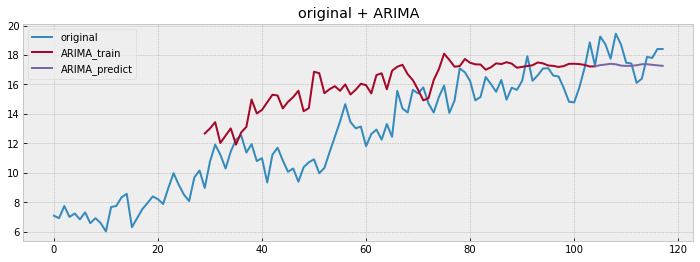

In [93]:
with plt.style.context(style='bmh'):
    plt.figure(figsize=(12,4))
    ax = plt.axes()
    plt.plot(series,label='original')
    
    plt.plot(range(delta,delta+len(y_train)+1),res.predict(delta,delta+len(y_train)),label='ARIMA_train' )
    plt.plot(range(delta+len(y_train), len(series) ),res.predict(delta+len(y_train), len(series)-1),label='ARIMA_predict' )
    plt.legend()
    plt.title('original + ARIMA')

Выводы: 
    
    Видно чем больше у ARIMA данных, тем лучше она предсказывает результат. 
    А Random Forest не плохо справился, хотя говорят он не умеет в экстраполяцию